In [1]:
import pandas as pd
import random

# Load with on_bad_lines='skip' to ignore malformed rows
df = pd.read_csv("data/players/player_stats_8seasons_20260121_211600.csv", 
                 on_bad_lines='skip')

print(f"Loaded {len(df)} records")
print(f"\nAll columns ({len(df.columns)}):")
print(df.columns.tolist())

Loaded 82608 records

All columns (73):
['match_id', 'player_id', 'name', 'team', 'position', 'shirt_number', 'fotmob_rating', 'minutes_played', 'goals', 'assists', 'total_shots', 'shotmap', 'accurate_passes', 'chances_created', 'expected_assists_(xa)', 'xg_+_xa', 'fantasy_points', 'defensive_actions', 'touches', 'touches_in_opposition_box', 'passes_into_final_third', 'accurate_crosses', 'accurate_long_balls', 'dispossessed', 'tackles', 'blocks', 'clearances', 'headed_clearance', 'interceptions', 'recoveries', 'dribbled_past', 'duels_won', 'duels_lost', 'ground_duels_won', 'aerial_duels_won', 'was_fouled', 'fouls_committed', 'season', 'expected_goals_(xg)', 'expected_goals_on_target_(xgot)', 'shots_on_target', 'big_chances_missed', 'xg_non-penalty', 'blocked_shots', 'successful_dribbles', 'saves', 'goals_conceded', 'xgot_faced', 'goals_prevented', 'acted_as_sweeper', 'high_claim', 'diving_save', 'saves_inside_box', 'punches', 'throws', 'corners', 'offsides', 'error_led_to_goal', 'conce

Comparing against 103 MIDs with 450+ minutes


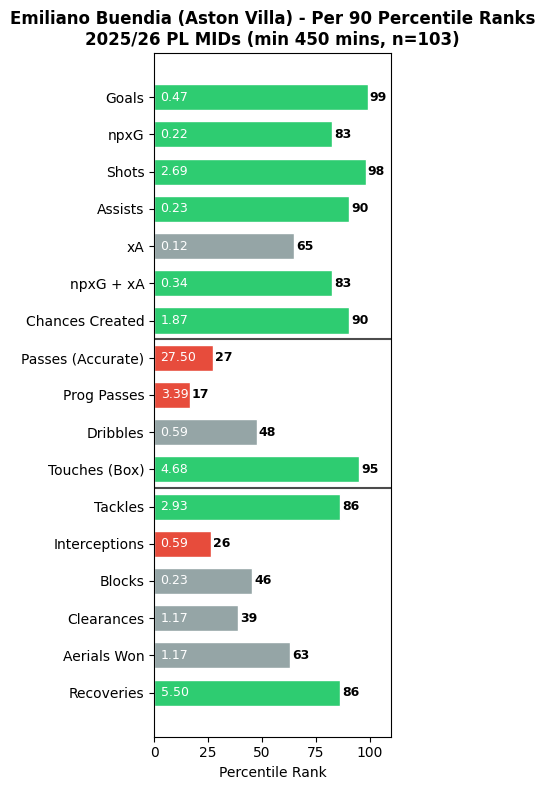


Emiliano Buendia - Per 90 Stats (vs MIDs):
Minutes: 769
  Goals: 0.47
  npxG: 0.22
  Shots: 2.69
  Assists: 0.23
  xA: 0.12
  npxG + xA: 0.34
  Chances Created: 1.87
  Passes (Accurate): 27.50
  Prog Passes: 3.39
  Dribbles: 0.59
  Touches (Box): 4.68
  Tackles: 2.93
  Interceptions: 0.59
  Blocks: 0.23
  Clearances: 1.17
  Aerials Won: 1.17
  Recoveries: 5.50


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("data/players/player_stats_8seasons_20260121_211600.csv", on_bad_lines='skip')

# Filter to current season
df_season = df[df['season'] == '2025/2026'].copy()

# Aggregate stats per player
agg_cols = {
    'minutes_played': 'sum',
    'goals': 'sum',
    'xg_non-penalty': 'sum',
    'total_shots': 'sum',
    'assists': 'sum',
    'expected_assists_(xa)': 'sum',
    'chances_created': 'sum',
    'accurate_passes': 'sum',
    'passes_into_final_third': 'sum',
    'successful_dribbles': 'sum',
    'touches_in_opposition_box': 'sum',
    'tackles': 'sum',
    'interceptions': 'sum',
    'blocks': 'sum',
    'clearances': 'sum',
    'aerial_duels_won': 'sum',
    'recoveries': 'sum',
}

player_totals = df_season.groupby(['player_id', 'name', 'team', 'position']).agg(agg_cols).reset_index()

# Filter to players with at least 450 minutes
player_totals = player_totals[player_totals['minutes_played'] >= 450].copy()

# Calculate per 90 stats
per90_cols = [c for c in agg_cols.keys() if c != 'minutes_played']
for col in per90_cols:
    player_totals[f'{col}_p90'] = player_totals[col] / player_totals['minutes_played'] * 90

# Calculate npxG + xA per 90
player_totals['npxg_xa_p90'] = player_totals['xg_non-penalty_p90'] + player_totals['expected_assists_(xa)_p90']

# Stats config
stats_config = {
    'Goals': 'goals_p90',
    'npxG': 'xg_non-penalty_p90',
    'Shots': 'total_shots_p90',
    'Assists': 'assists_p90',
    'xA': 'expected_assists_(xa)_p90',
    'npxG + xA': 'npxg_xa_p90',
    'Chances Created': 'chances_created_p90',
    'Passes (Accurate)': 'accurate_passes_p90',
    'Prog Passes': 'passes_into_final_third_p90',
    'Dribbles': 'successful_dribbles_p90',
    'Touches (Box)': 'touches_in_opposition_box_p90',
    'Tackles': 'tackles_p90',
    'Interceptions': 'interceptions_p90',
    'Blocks': 'blocks_p90',
    'Clearances': 'clearances_p90',
    'Aerials Won': 'aerial_duels_won_p90',
    'Recoveries': 'recoveries_p90',
}

# Get player's data first to find position
player_name = 'Emiliano Buendia'
player_data = player_totals[player_totals['name'] == player_name]

if len(player_data) == 0:
    print(f"Player '{player_name}' not found.")
else:
    player_row = player_data.iloc[0]
    player_position = player_row['position']
    
    # Filter to only players with same position
    position_df = player_totals[player_totals['position'] == player_position].copy()
    position_count = len(position_df)
    
    # Map position number to name
    position_names = {0: 'GK', 1: 'DEF', 2: 'MID', 3: 'FWD'}
    position_name = position_names.get(player_position, f'Position {player_position}')
    
    print(f"Comparing against {position_count} {position_name}s with 450+ minutes")
    
    # Calculate percentile ranks within same position
    for stat_name, col in stats_config.items():
        position_df[f'{col}_pct'] = position_df[col].rank(pct=True) * 100
    
    # Get updated player row
    player_row = position_df[position_df['name'] == player_name].iloc[0]
    
    # Extract percentiles
    labels = list(stats_config.keys())
    percentiles = [player_row[f'{col}_pct'] for col in stats_config.values()]
    
    # Color function
    def get_color(pct):
        if pct >= 66:
            return '#2ecc71'  # green
        elif pct >= 33:
            return '#95a5a6'  # gray
        else:
            return '#e74c3c'  # red
    
    colors = [get_color(p) for p in percentiles]
    
    # Get actual values for display
    actual_values = [player_row[col] for col in stats_config.values()]
    
    # Create horizontal bar chart
    fig, ax = plt.subplots(figsize=(4, 8))
    y_pos = np.arange(len(labels))
    bars = ax.barh(y_pos, percentiles, color=colors, edgecolor='white', height=0.7)
    
    # Add percentile and actual value labels
    for i, (bar, pct, val) in enumerate(zip(bars, percentiles, actual_values)):
        ax.text(pct + 1, i, f'{pct:.0f}', va='center', ha='left', fontsize=9, fontweight='bold')
        ax.text(3, i, f'{val:.2f}', va='center', ha='left', fontsize=9, color='white')
    
    # Add horizontal separators between sections
    # Section 1: Goals to Chances Created (indices 0-6)
    # Section 2: Passes to Touches Box (indices 7-10)
    # Section 3: Tackles to Aerials Won (indices 11-15)
    ax.axhline(y=6.5, color='black', linestyle='-', linewidth=1.5, alpha=0.7)
    ax.axhline(y=10.5, color='black', linestyle='-', linewidth=1.5, alpha=0.7)
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels)
    ax.set_xlabel('Percentile Rank')
    ax.set_xlim(0, 110)
    ax.set_title(f"{player_name} ({player_row['team']}) - Per 90 Percentile Ranks\n2025/26 PL {position_name}s (min 450 mins, n={position_count})", fontweight='bold')
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print(f"\n{player_name} - Per 90 Stats (vs {position_name}s):")
    print(f"Minutes: {player_row['minutes_played']:.0f}")
    for stat_name, col in stats_config.items():
        print(f"  {stat_name}: {player_row[col]:.2f}")

In [3]:
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv("data/players/player_stats_8seasons_20260121_211600.csv", on_bad_lines='skip')

# Filter to 2025-2026 season
df_season = df[df['season'] == '2025/2026'].copy()

# Aggregate stats per player
player_stats = df_season.groupby(['player_id', 'name', 'team']).agg({
    'minutes_played': 'sum',
    'expected_goals_(xg)': 'sum',
    'expected_assists_(xa)': 'sum',
    'xg_non-penalty': 'sum',
}).reset_index()

# Filter players with at least 450 minutes
player_stats = player_stats[player_stats['minutes_played'] >= 450].copy()

# Calculate per 90 stats
player_stats['xg_per_90'] = (player_stats['expected_goals_(xg)'] / player_stats['minutes_played']) * 90
player_stats['xa_per_90'] = (player_stats['expected_assists_(xa)'] / player_stats['minutes_played']) * 90
player_stats['npxg_per_90'] = (player_stats['xg_non-penalty'] / player_stats['minutes_played']) * 90
player_stats['npxg_xa_per_90'] = player_stats['npxg_per_90'] + player_stats['xa_per_90']

# Sort by npxG+xA per 90 and get top 25
top_25 = player_stats.nlargest(25, 'npxg_xa_per_90')[['name', 'team', 'minutes_played', 'npxg_xa_per_90', 'xg_per_90', 'xa_per_90', 'npxg_per_90']].copy()

# Round stats for readability
top_25['xg_per_90'] = top_25['xg_per_90'].round(2)
top_25['xa_per_90'] = top_25['xa_per_90'].round(2)
top_25['npxg_per_90'] = top_25['npxg_per_90'].round(2)
top_25['npxg_xa_per_90'] = top_25['npxg_xa_per_90'].round(2)

# Rename columns for display
top_25.columns = ['Player', 'Team', 'Minutes', 'npxG+xA/90', 'xG/90', 'xA/90', 'npxG/90']

# Reset index for display
top_25 = top_25.reset_index(drop=True)
top_25.index = top_25.index + 1

print("Top 25 Players by npxG+xA per 90 (2025-26, min 450 mins)")
display(top_25)

Top 25 Players by npxG+xA per 90 (2025-26, min 450 mins)


,Player,Team,Minutes,npxG+xA/90,xG/90,xA/90,npxG/90
1,Erling Haaland,Manchester City,1906.0,0.83,0.88,0.07,0.77
2,Rayan Cherki,Manchester City,886.0,0.71,0.17,0.54,0.17
3,David Brooks,Bournemouth,942.0,0.69,0.42,0.27,0.42
4,Estevao,Chelsea,604.0,0.67,0.35,0.32,0.35
5,Donyell Malen,Aston Villa,645.0,0.61,0.56,0.05,0.56
6,Hugo Ekitike,Liverpool,1227.0,0.61,0.47,0.13,0.47
7,Bryan Mbeumo,Manchester United,1475.0,0.60,0.39,0.21,0.39
8,Bukayo Saka,Arsenal,1459.0,0.58,0.34,0.29,0.29
9,Harvey Barnes,Newcastle United,1039.0,0.55,0.39,0.16,0.39
10,Enzo Fernández,Chelsea,1788.0,0.55,0.39,0.20,0.35


In [1]:
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv("data/players/player_stats_8seasons_20260121_211600.csv", on_bad_lines='skip')

# Filter to 2025-2026 season
df_season = df[df['season'] == '2025/2026'].copy()

# Aggregate stats per player
player_stats = df_season.groupby(['player_id', 'name', 'team']).agg({
    'minutes_played': 'sum',
    'expected_goals_(xg)': 'sum',
    'expected_assists_(xa)': 'sum',
    'xg_non-penalty': 'sum',
}).reset_index()

# Calculate npxG + xA (non-penalty xG + xA)
player_stats['npxg_plus_xa'] = player_stats['xg_non-penalty'] + player_stats['expected_assists_(xa)']

# Filter players with at least 450 minutes
player_stats = player_stats[player_stats['minutes_played'] >= 450].copy()

# Calculate per 90 stats
player_stats['xg_per_90'] = (player_stats['expected_goals_(xg)'] / player_stats['minutes_played']) * 90
player_stats['xa_per_90'] = (player_stats['expected_assists_(xa)'] / player_stats['minutes_played']) * 90
player_stats['npxg_per_90'] = (player_stats['xg_non-penalty'] / player_stats['minutes_played']) * 90

# Sort by npxG + xA and get top 25
top_25 = player_stats.nlargest(25, 'npxg_plus_xa')[['name', 'team', 'minutes_played', 'npxg_plus_xa', 'xg_per_90', 'xa_per_90', 'npxg_per_90']].copy()

# Round stats for readability
top_25['xg_per_90'] = top_25['xg_per_90'].round(2)
top_25['xa_per_90'] = top_25['xa_per_90'].round(2)
top_25['npxg_per_90'] = top_25['npxg_per_90'].round(2)
top_25['npxg_plus_xa'] = top_25['npxg_plus_xa'].round(2)

# Rename columns for display
top_25.columns = ['Player', 'Team', 'Minutes', 'npxG+xA', 'xG/90', 'xA/90', 'npxG/90']

# Reset index for display
top_25 = top_25.reset_index(drop=True)
top_25.index = top_25.index + 1

display(top_25)

,Player,Team,Minutes,npxG+xA,xG/90,xA/90,npxG/90
1,Erling Haaland,Manchester City,1906.0,17.68,0.88,0.07,0.77
2,Enzo Fernández,Chelsea,1788.0,10.96,0.39,0.20,0.35
3,Jean-Philippe Mateta,Crystal Palace,1829.0,10.38,0.57,0.06,0.45
4,Bryan Mbeumo,Manchester United,1475.0,9.78,0.39,0.21,0.39
5,Bruno Fernandes,Manchester United,1627.0,9.47,0.39,0.31,0.21
6,Ollie Watkins,Aston Villa,1661.0,9.40,0.46,0.05,0.46
7,Bukayo Saka,Arsenal,1459.0,9.40,0.34,0.29,0.29
8,Kevin Schade,Brentford,1733.0,9.03,0.43,0.08,0.39
9,Igor Thiago,Brentford,1844.0,8.88,0.62,0.04,0.39
10,Phil Foden,Manchester City,1615.0,8.55,0.28,0.19,0.28


In [5]:
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv("data/players/player_stats_8seasons_20260121_211600.csv", on_bad_lines='skip')

# Filter to 2025-2026 season
df_season = df[df['season'] == '2025/2026'].copy()

# Aggregate stats per player
player_stats = df_season.groupby(['player_id', 'name', 'team']).agg({
    'minutes_played': 'sum',
    'expected_goals_(xg)': 'sum',
    'expected_assists_(xa)': 'sum',
    'xg_non-penalty': 'sum',
}).reset_index()

# Calculate total xG + xA
player_stats['xg_plus_xa'] = player_stats['expected_goals_(xg)'] + player_stats['expected_assists_(xa)']

# Filter players with at least 450 minutes
player_stats = player_stats[player_stats['minutes_played'] >= 450].copy()

# Calculate per 90 stats
player_stats['xg_per_90'] = (player_stats['expected_goals_(xg)'] / player_stats['minutes_played']) * 90
player_stats['xa_per_90'] = (player_stats['expected_assists_(xa)'] / player_stats['minutes_played']) * 90
player_stats['npxg_per_90'] = (player_stats['xg_non-penalty'] / player_stats['minutes_played']) * 90

# Sort by xG + xA and get top 25
top_25 = player_stats.nlargest(25, 'xg_plus_xa')[['name', 'team', 'minutes_played', 'xg_plus_xa', 'xg_per_90', 'xa_per_90', 'npxg_per_90']].copy()

# Round per-90 stats for readability
top_25['xg_per_90'] = top_25['xg_per_90'].round(2)
top_25['xa_per_90'] = top_25['xa_per_90'].round(2)
top_25['npxg_per_90'] = top_25['npxg_per_90'].round(2)
top_25['xg_plus_xa'] = top_25['xg_plus_xa'].round(2)

# Rename columns for display
top_25.columns = ['Player', 'Team', 'Minutes', 'xG+xA', 'xG/90', 'xA/90', 'npxG/90']

# Reset index for display
top_25 = top_25.reset_index(drop=True)
top_25.index = top_25.index + 1

display(top_25)

,Player,Team,Minutes,xG+xA,xG/90,xA/90,npxG/90
1,Erling Haaland,Manchester City,1906.0,20.05,0.88,0.07,0.77
2,Igor Thiago,Brentford,1844.0,13.62,0.62,0.04,0.39
3,Jean-Philippe Mateta,Crystal Palace,1829.0,12.75,0.57,0.06,0.45
4,Bruno Fernandes,Manchester United,1627.0,12.63,0.39,0.31,0.21
5,Enzo Fernández,Chelsea,1788.0,11.75,0.39,0.20,0.35
6,Bukayo Saka,Arsenal,1459.0,10.19,0.34,0.29,0.29
7,Kevin Schade,Brentford,1733.0,9.82,0.43,0.08,0.39
8,Bryan Mbeumo,Manchester United,1475.0,9.78,0.39,0.21,0.39
9,Ollie Watkins,Aston Villa,1661.0,9.40,0.46,0.05,0.46
10,Dominic Calvert-Lewin,Leeds United,1404.0,9.08,0.52,0.06,0.42


Comparing against 97 FWDs with 450+ minutes


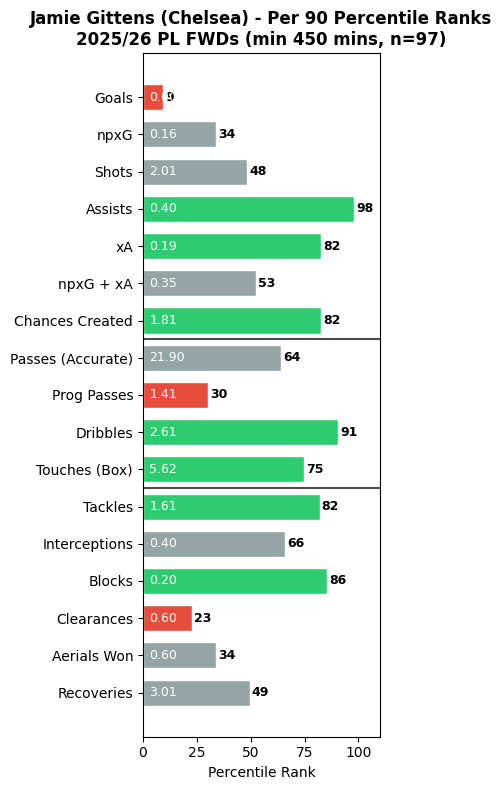


Jamie Gittens - Per 90 Stats (vs FWDs):
Minutes: 448
  Goals: 0.00
  npxG: 0.16
  Shots: 2.01
  Assists: 0.40
  xA: 0.19
  npxG + xA: 0.35
  Chances Created: 1.81
  Passes (Accurate): 21.90
  Prog Passes: 1.41
  Dribbles: 2.61
  Touches (Box): 5.62
  Tackles: 1.61
  Interceptions: 0.40
  Blocks: 0.20
  Clearances: 0.60
  Aerials Won: 0.60
  Recoveries: 3.01


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("data/players/player_stats_8seasons_20260121_211600.csv", on_bad_lines='skip')

# Filter to current season
df_season = df[df['season'] == '2025/2026'].copy()

# Aggregate stats per player
agg_cols = {
    'minutes_played': 'sum',
    'goals': 'sum',
    'xg_non-penalty': 'sum',
    'total_shots': 'sum',
    'assists': 'sum',
    'expected_assists_(xa)': 'sum',
    'chances_created': 'sum',
    'accurate_passes': 'sum',
    'passes_into_final_third': 'sum',
    'successful_dribbles': 'sum',
    'touches_in_opposition_box': 'sum',
    'tackles': 'sum',
    'interceptions': 'sum',
    'blocks': 'sum',
    'clearances': 'sum',
    'aerial_duels_won': 'sum',
    'recoveries': 'sum',
}

player_totals = df_season.groupby(['player_id', 'name', 'team', 'position']).agg(agg_cols).reset_index()

# Filter to players with at least 450 minutes
player_totals = player_totals[player_totals['minutes_played'] >= 300].copy()

# Calculate per 90 stats
per90_cols = [c for c in agg_cols.keys() if c != 'minutes_played']
for col in per90_cols:
    player_totals[f'{col}_p90'] = player_totals[col] / player_totals['minutes_played'] * 90

# Calculate npxG + xA per 90
player_totals['npxg_xa_p90'] = player_totals['xg_non-penalty_p90'] + player_totals['expected_assists_(xa)_p90']

# Stats config
stats_config = {
    'Goals': 'goals_p90',
    'npxG': 'xg_non-penalty_p90',
    'Shots': 'total_shots_p90',
    'Assists': 'assists_p90',
    'xA': 'expected_assists_(xa)_p90',
    'npxG + xA': 'npxg_xa_p90',
    'Chances Created': 'chances_created_p90',
    'Passes (Accurate)': 'accurate_passes_p90',
    'Prog Passes': 'passes_into_final_third_p90',
    'Dribbles': 'successful_dribbles_p90',
    'Touches (Box)': 'touches_in_opposition_box_p90',
    'Tackles': 'tackles_p90',
    'Interceptions': 'interceptions_p90',
    'Blocks': 'blocks_p90',
    'Clearances': 'clearances_p90',
    'Aerials Won': 'aerial_duels_won_p90',
    'Recoveries': 'recoveries_p90',
}

# Get player's data first to find position
player_name = 'Jamie Gittens'
player_data = player_totals[player_totals['name'].str.contains("Gittens")]

if len(player_data) == 0:
    print(f"Player '{player_name}' not found.")
else:
    player_row = player_data.iloc[0]
    player_position = player_row['position']
    
    # Filter to only players with same position
    position_df = player_totals[player_totals['position'] == player_position].copy()
    position_count = len(position_df)
    
    # Map position number to name
    position_names = {0: 'GK', 1: 'DEF', 2: 'MID', 3: 'FWD'}
    position_name = position_names.get(player_position, f'Position {player_position}')
    
    print(f"Comparing against {position_count} {position_name}s with 450+ minutes")
    
    # Calculate percentile ranks within same position
    for stat_name, col in stats_config.items():
        position_df[f'{col}_pct'] = position_df[col].rank(pct=True) * 100
    
    # Get updated player row
    player_row = position_df[position_df['name'].str.contains("Gittens")].iloc[0]
    
    # Extract percentiles
    labels = list(stats_config.keys())
    percentiles = [player_row[f'{col}_pct'] for col in stats_config.values()]
    
    # Color function
    def get_color(pct):
        if pct >= 66:
            return '#2ecc71'  # green
        elif pct >= 33:
            return '#95a5a6'  # gray
        else:
            return '#e74c3c'  # red
    
    colors = [get_color(p) for p in percentiles]
    
    # Get actual values for display
    actual_values = [player_row[col] for col in stats_config.values()]
    
    # Create horizontal bar chart
    fig, ax = plt.subplots(figsize=(4, 8))
    y_pos = np.arange(len(labels))
    bars = ax.barh(y_pos, percentiles, color=colors, edgecolor='white', height=0.7)
    
    # Add percentile and actual value labels
    for i, (bar, pct, val) in enumerate(zip(bars, percentiles, actual_values)):
        ax.text(pct + 1, i, f'{pct:.0f}', va='center', ha='left', fontsize=9, fontweight='bold')
        ax.text(3, i, f'{val:.2f}', va='center', ha='left', fontsize=9, color='white')
    
    # Add horizontal separators between sections
    # Section 1: Goals to Chances Created (indices 0-6)
    # Section 2: Passes to Touches Box (indices 7-10)
    # Section 3: Tackles to Aerials Won (indices 11-15)
    ax.axhline(y=6.5, color='black', linestyle='-', linewidth=1.5, alpha=0.7)
    ax.axhline(y=10.5, color='black', linestyle='-', linewidth=1.5, alpha=0.7)
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels)
    ax.set_xlabel('Percentile Rank')
    ax.set_xlim(0, 110)
    ax.set_title(f"{player_name} ({player_row['team']}) - Per 90 Percentile Ranks\n2025/26 PL {position_name}s (min 450 mins, n={position_count})", fontweight='bold')
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print(f"\n{player_name} - Per 90 Stats (vs {position_name}s):")
    print(f"Minutes: {player_row['minutes_played']:.0f}")
    for stat_name, col in stats_config.items():
        print(f"  {stat_name}: {player_row[col]:.2f}")

In [7]:
# Check xG availability by season
xg_by_season = df.groupby('season')['expected_assists_(xa)'].agg(['count', 'size'])
xg_by_season['pct_available'] = (xg_by_season['count'] / xg_by_season['size'] * 100).round(1)
xg_by_season.columns = ['has_xg', 'total_rows', 'pct_available']
print(xg_by_season.sort_index())

           has_xg  total_rows  pct_available
season                                      
2018/2019      17       10485            0.2
2019/2020      83       10513            0.8
2020/2021    7100       10277           69.1
2021/2022    7284       10482           69.5
2022/2023    7576       11310           67.0
2023/2024    7903       11377           69.5
2024/2025    7922       11498           68.9
2025/2026    4575        6666           68.6


In [8]:
from src.pipeline import FPLPipeline

pipeline = FPLPipeline('data')
pipeline.load_data()
pipeline.compute_features()
#pipeline.train()
pipeline.tune(n_iter=100, use_subprocess=True)
predictions = pipeline.predict(gameweek=23, season='2025/2026')

# Top 20 by expected points with full prediction breakdown
display_cols = [
    'player_name', 'team', 'fpl_position', 'opponent', 'is_home',
    'pred_minutes', 'pred_exp_goals', 'pred_exp_assists', 
    'pred_cs_prob', 'pred_defcon_prob','pred_bonus', 'exp_total_pts'
]
available_cols = [c for c in display_cols if c in predictions.columns]
predictions.nlargest(20, 'exp_total_pts')[available_cols].round(2)

LOADING DATA
Loading player stats from: player_stats_8seasons_20260127_185152.csv
  Loaded 81,633 player-match records
  Seasons: ['2018/2019', '2019/2020', '2020/2021', '2021/2022', '2022/2023', '2023/2024', '2024/2025', '2025/2026']
Loaded 2,891 fixtures
  Removed 220 duplicate fixtures
Filtered to seasons: ['2020/2021', '2021/2022', '2022/2023', '2023/2024', '2024/2025', '2025/2026']
Current season (2025/2026): 496 active players
Final dataset: 61,360 records

COMPUTING FEATURES
Computing rolling features...
  Computed 84 rolling/lifetime features

TUNING HYPERPARAMETERS (subprocess mode)

Tuning GOALS (100 iterations) in subprocess...
  Best RMSE: 0.4185
  Params: {'learning_rate': 0.023545774516299134, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 212}

Tuning ASSISTS (100 iterations) in subprocess...
  Best RMSE: 0.3464
  Params: {'learning_rate': 0.024281545065610324, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 136}

Tuning MINUTES (100 iterations) in subproc

,player_name,team,fpl_position,opponent,is_home,pred_minutes,pred_exp_goals,pred_exp_assists,pred_cs_prob,pred_defcon_prob,pred_bonus,exp_total_pts
39,Mohamed Salah,Liverpool,MID,Bournemouth,0,88.000000,0.42,0.20,0.60,0.00,0.59,5.90
388,Max Alleyne,Manchester City,DEF,Wolves,1,88.000000,0.09,0.06,0.43,0.53,0.39,5.86
123,Erling Haaland,Manchester City,FWD,Wolves,1,88.500000,0.60,0.10,0.43,0.00,1.07,5.76
21,Virgil van Dijk,Liverpool,DEF,Bournemouth,0,89.260002,0.06,0.03,0.60,0.39,0.13,5.72
166,Ibrahima Konaté,Liverpool,DEF,Bournemouth,0,88.059998,0.03,0.03,0.60,0.49,0.08,5.70
235,Nathan Collins,Brentford,DEF,Nott'm Forest,1,88.430000,0.06,0.06,0.42,0.64,0.22,5.69
324,Milos Kerkez,Liverpool,DEF,Bournemouth,0,84.959999,0.02,0.08,0.60,0.23,0.35,5.57
360,Igor Thiago,Brentford,FWD,Nott'm Forest,1,88.000000,0.54,0.05,0.42,0.01,1.02,5.36
114,Ethan Pinnock,Brentford,DEF,Nott'm Forest,1,88.000000,0.05,0.04,0.42,0.55,0.10,5.30
392,Michael Kayode,Brentford,DEF,Nott'm Forest,1,88.000000,0.03,0.09,0.42,0.47,0.26,5.28


In [9]:
predictions.loc[predictions['fpl_position'] == "FWD"].nlargest(10, 'exp_total_pts')[available_cols].round(2)

,player_name,team,fpl_position,opponent,is_home,pred_minutes,pred_exp_goals,pred_exp_assists,pred_cs_prob,pred_defcon_prob,pred_bonus,exp_total_pts
123,Erling Haaland,Manchester City,FWD,Wolves,1,88.500000,0.60,0.10,0.43,0.00,1.07,5.76
360,Igor Thiago,Brentford,FWD,Nott'm Forest,1,88.000000,0.54,0.05,0.42,0.01,1.02,5.36
325,Hugo Ekitike,Liverpool,FWD,Bournemouth,0,88.000000,0.40,0.12,0.60,0.00,0.77,4.73
64,Jarrod Bowen,West Ham United,FWD,Sunderland,1,88.699997,0.37,0.13,0.35,0.04,0.79,4.65
14,Callum Wilson,West Ham United,FWD,Sunderland,1,76.690002,0.40,0.07,0.35,0.00,0.65,4.45
85,Dominic Calvert-Lewin,Leeds United,FWD,Everton,0,81.860001,0.33,0.06,0.29,0.00,0.74,4.24
111,Jean-Philippe Mateta,Crystal Palace,FWD,Chelsea,1,88.000000,0.35,0.05,0.22,0.01,0.62,4.18
69,Ollie Watkins,Aston Villa,FWD,Newcastle,0,83.489998,0.31,0.09,0.19,0.00,0.63,4.16
102,Yoane Wissa,Newcastle United,FWD,Aston Villa,1,66.639999,0.32,0.07,0.25,0.00,0.60,4.08
38,Raul Jiménez,Fulham,FWD,Brighton,1,88.000000,0.28,0.09,0.17,0.01,0.60,4.01


In [10]:
predictions.loc[predictions['fpl_position'] == "MID"].nlargest(10, 'exp_total_pts')[available_cols].round(2)

,player_name,team,fpl_position,opponent,is_home,pred_minutes,pred_exp_goals,pred_exp_assists,pred_cs_prob,pred_defcon_prob,pred_bonus,exp_total_pts
39,Mohamed Salah,Liverpool,MID,Bournemouth,0,88.000000,0.42,0.20,0.60,0.00,0.59,5.90
310,Florian Wirtz,Liverpool,MID,Bournemouth,0,88.000000,0.31,0.17,0.60,0.05,0.52,5.24
51,Bruno Fernandes,Manchester United,MID,Arsenal,0,84.690002,0.28,0.23,0.29,0.20,0.41,5.18
163,Phil Foden,Manchester City,MID,Wolves,1,88.000000,0.30,0.22,0.43,0.02,0.44,5.07
134,Harvey Barnes,Newcastle United,MID,Aston Villa,1,78.089996,0.34,0.14,0.25,0.00,0.53,4.94
343,Dango Ouattara,Brentford,MID,Nott'm Forest,1,88.000000,0.27,0.11,0.42,0.24,0.30,4.87
213,Bryan Mbeumo,Manchester United,MID,Arsenal,0,88.000000,0.34,0.16,0.29,0.02,0.29,4.79
161,Cody Gakpo,Liverpool,MID,Bournemouth,0,81.139999,0.32,0.09,0.60,0.00,0.29,4.78
201,Anton Stach,Leeds United,MID,Everton,0,88.000000,0.18,0.18,0.29,0.30,0.32,4.65
20,Casemiro,Manchester United,MID,Arsenal,0,81.059998,0.15,0.11,0.29,0.54,0.20,4.64


In [11]:
predictions.loc[predictions['fpl_position'] == "DEF"].nlargest(10, 'exp_total_pts')[available_cols].round(2)

,player_name,team,fpl_position,opponent,is_home,pred_minutes,pred_exp_goals,pred_exp_assists,pred_cs_prob,pred_defcon_prob,pred_bonus,exp_total_pts
388,Max Alleyne,Manchester City,DEF,Wolves,1,88.000000,0.09,0.06,0.43,0.53,0.39,5.86
21,Virgil van Dijk,Liverpool,DEF,Bournemouth,0,89.260002,0.06,0.03,0.60,0.39,0.13,5.72
166,Ibrahima Konaté,Liverpool,DEF,Bournemouth,0,88.059998,0.03,0.03,0.60,0.49,0.08,5.70
235,Nathan Collins,Brentford,DEF,Nott'm Forest,1,88.430000,0.06,0.06,0.42,0.64,0.22,5.69
324,Milos Kerkez,Liverpool,DEF,Bournemouth,0,84.959999,0.02,0.08,0.60,0.23,0.35,5.57
114,Ethan Pinnock,Brentford,DEF,Nott'm Forest,1,88.000000,0.05,0.04,0.42,0.55,0.10,5.30
392,Michael Kayode,Brentford,DEF,Nott'm Forest,1,88.000000,0.03,0.09,0.42,0.47,0.26,5.28
230,Matheus Nunes,Manchester City,DEF,Wolves,1,88.000000,0.04,0.11,0.43,0.36,0.23,5.20
149,Cristian Romero,Tottenham Hotspur,DEF,Burnley,0,88.000000,0.07,0.07,0.22,0.68,0.23,5.09
211,Sepp van den Berg,Brentford,DEF,Nott'm Forest,1,88.790001,0.05,0.03,0.42,0.46,0.10,5.08


In [12]:
predictions[predictions['player_name'].str.contains("Haaland")][display_cols]

,player_name,team,fpl_position,opponent,is_home,pred_minutes,pred_exp_goals,pred_exp_assists,pred_cs_prob,pred_defcon_prob,pred_bonus,exp_total_pts
123,Erling Haaland,Manchester City,FWD,Wolves,1,88.495918,0.596871,0.101157,0.426532,0.001009,1.069,5.759957


In [13]:
import pandas as pd
df = pd.read_csv('data/predictions/gw23_2025-2026.csv')
print('Teams in predictions:')
print(sorted(df['team'].unique()))

Teams in predictions:
['Arsenal', 'Aston Villa', 'Bournemouth', 'Brentford', 'Brighton and Hove Albion', 'Burnley', 'Chelsea', 'Crystal Palace', 'Everton', 'Fulham', 'Leeds United', 'Liverpool', 'Manchester City', 'Manchester United', 'Newcastle United', 'Nottingham Forest', 'Sunderland', 'Tottenham Hotspur', 'West Ham United', 'Wolverhampton Wanderers']


In [ ]:
# GW24 Players Ranked by npxG + xA
import pandas as pd

# Load raw player stats
df = pd.read_csv("data/players/player_stats_8seasons_20260127_185152.csv", on_bad_lines="skip")

# Filter to current season and GW24
gw24 = df[(df["season"] == "2025/2026") & (df["match_id"].str.contains("GW24", case=False, na=False))].copy()

# Calculate npxG + xA
gw24["npxg"] = pd.to_numeric(gw24["xg_non-penalty"], errors="coerce").fillna(0)
gw24["xa"] = pd.to_numeric(gw24["expected_assists_(xa)"], errors="coerce").fillna(0)
gw24["npxg_xa"] = gw24["npxg"] + gw24["xa"]

# Select and display top players by npxG + xA
cols = ["name", "team", "position", "minutes_played", "goals", "assists", "npxg", "xa", "npxg_xa"]
gw24_ranked = gw24[cols].sort_values("npxg_xa", ascending=False).head(25)
print("GW24 Players Ranked by npxG + xA (Top 25):")
gw24_ranked

In [ ]:
# GW24 Players Ranked by npxG + xA
import pandas as pd

# Load raw player stats and fixtures (auto-find latest file)
import glob, os
player_files = glob.glob("data/players/player_stats_8seasons_*.csv")
latest_file = max(player_files, key=os.path.getmtime)
print(f"Using: {latest_file}")
df = pd.read_csv(latest_file, on_bad_lines="skip")
fixtures = pd.read_csv("data/all_fixtures_8_seasons.csv")

# Get GW24 match_ids for current season
gw24_match_ids = fixtures[(fixtures["season"] == "2025/2026") & (fixtures["round"] == 24)]["match_id"].tolist()

# Filter player data to GW24 matches
gw24 = df[df["match_id"].isin(gw24_match_ids)].copy()

# Calculate npxG + xA
gw24["npxg"] = pd.to_numeric(gw24["xg_non-penalty"], errors="coerce").fillna(0)
gw24["xa"] = pd.to_numeric(gw24["expected_assists_(xa)"], errors="coerce").fillna(0)
gw24["npxg_xa"] = gw24["npxg"] + gw24["xa"]

# Select and display top players by npxG + xA
cols = ["name", "team", "position", "minutes_played", "goals", "assists", "npxg", "xa", "npxg_xa"]
gw24_ranked = gw24[cols].sort_values("npxg_xa", ascending=False).head(25)
print(f"GW24 Players Ranked by npxG + xA (Top 25) - {len(gw24)} players in GW24:")
gw24_ranked

Using: data/players\player_stats_8seasons_20260202_174053.csv
GW24 Players Ranked by npxG + xA (Top 25) - 302 players in GW24:


,name,team,position,minutes_played,goals,assists,npxg,xa,npxg_xa
81785,Hugo Ekitike,Liverpool,3.0,84.0,2.0,0.0,1.16,0.03,1.19
81741,Marc Cucurella,Chelsea,1.0,45.0,1.0,0.0,0.81,0.10,0.91
81749,Liam Delap,Chelsea,3.0,90.0,0.0,0.0,0.89,0.01,0.90
81721,Alex Scott,Bournemouth,2.0,90.0,1.0,0.0,0.82,0.01,0.83
81895,Xavi Simons,Tottenham Hotspur,2.0,90.0,0.0,1.0,0.21,0.56,0.77
81668,Gabriel Jesus,Arsenal,3.0,14.0,1.0,0.0,0.74,0.00,0.74
81799,Tammy Abraham,Aston Villa,3.0,90.0,0.0,0.0,0.64,0.08,0.72
81747,Cole Palmer,Chelsea,2.0,90.0,0.0,0.0,0.65,0.05,0.70
81643,Kaoru Mitoma,Brighton and Hove Albion,3.0,90.0,0.0,0.0,0.49,0.21,0.70
81711,Tolu Arokodare,Wolverhampton Wanderers,3.0,90.0,0.0,0.0,0.65,0.04,0.69


: 